### Analyze the Spread of Novel CoronaVirus 
#### Data Source: [Johns Hopkins University](https://docs.google.com/spreadsheets/d/1wQVypefm946ch4XDp37uZ-wartW4V7ILdg-qYiDXUHM/htmlview?sle=true)

#### How to [access](https://towardsdatascience.com/accessing-google-spreadsheet-data-using-python-90a5bc214fd2) 

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta

import gspread
from oauth2client.service_account import ServiceAccountCredentials

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import acf

In [2]:
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('client_secret.json', scope)
client = gspread.authorize(creds)

#### Load all sheets in the underlying file

In [3]:
##sheet = client.open('Learning Log').sheet1
sheet = client.open_by_url('https://docs.google.com/spreadsheets/d/1wQVypefm946ch4XDp37uZ-wartW4V7ILdg-qYiDXUHM/htmlview?sle=true')
worksheet_list = sheet.worksheets()

len(worksheet_list)

raw_df = pd.DataFrame()
for worksheet in worksheet_list:
    sub_data = worksheet.get_all_records()
    sub_table = pd.DataFrame(sub_data)
    sub_table['sheet_name'] = worksheet._properties['title']
    raw_df = pd.concat([raw_df, sub_table])

raw_df.head()

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


,,Confirmed,Country,Country/Region,Date last updated,Deaths,Demised,Last Update,Province/State,"Quick note: Starting from this tab, our map is updating (almost) in real time (China data - at least once per hour; non China data - several times per day). This table is planning to be updated twice a day. The discrepancy between the map and this sheet is expected. Sorry for any confusion and inconvenience.",Recovered,Suspected,sheet_name
0,NaN,16678,NaN,Mainland China,NaN,479,NaN,2/5/20 16:43,Hubei,NaN,538,NaN,Feb05_1220PM
1,NaN,895,NaN,Mainland China,NaN,0,NaN,2/5/20 13:23,Guangdong,NaN,49,NaN,Feb05_1220PM
2,NaN,895,NaN,Mainland China,NaN,0,NaN,2/5/20 15:13,Zhejiang,NaN,78,NaN,Feb05_1220PM
3,NaN,764,NaN,Mainland China,NaN,2,NaN,2/5/20 15:03,Henan,NaN,47,NaN,Feb05_1220PM
4,NaN,661,NaN,Mainland China,NaN,0,NaN,2/5/20 15:23,Hunan,NaN,54,NaN,Feb05_1220PM


In [4]:
# Merge duplicate columns with different names

main_df = raw_df

main_df.loc[main_df.Deaths.isna(),'Deaths'] =  main_df.loc[main_df.Deaths.isna(),'Demised']

main_df.loc[main_df['Country/Region'].isna(),'Country/Region'] =  main_df.loc[main_df['Country/Region'].isna(),'Country']
#main_df.loc[main_df['Country/Region'].isna(),'Country/Region'] =  main_df.loc[main_df['Country/Region'].isna(),'Country_Region']

#main_df.loc[main_df['Province/State'].isna(),'Province/State'] =  main_df.loc[main_df['Province/State'].isna(),'Province_State']

main_df.loc[main_df['Last Update'].isna(),'Last Update'] = main_df.loc[main_df['Last Update'].isna(),'Date last updated']
#main_df.loc[main_df['Last Update (UTC)'].isna(),'Last Update (UTC)'] = main_df.loc[main_df['Last Update (UTC)'].isna(),'Last_Update']
#main_df.loc[main_df['Last Update'].isna(),'Last Update'] = main_df.loc[main_df['Last Update'].isna(),'Last Update (UTC)']

main_df.loc[main_df['Province/State'].isna(), 'Province/State'] = main_df.loc[main_df['Province/State'].isna(), 'Country/Region']
main_df.loc[main_df['Province/State']=='', 'Province/State'] = main_df.loc[main_df['Province/State']=='', 'Country/Region']

main_df = main_df.loc[:, ~main_df.columns.isin(['Demised' , 'Country' , 'Country_Region','Province_State',
                                                'Date last updated', 'Last Update (UTC)', 'Last_Update','',
                                               'Quick note: Starting from this tab, our map is updating (almost) in real time (China data - at least once per hour; non China data - several times per day). This table is planning to be updated twice a day. The discrepancy between the map and this sheet is expected. Sorry for any confusion and inconvenience.'])]
main_df.sample(5)

,Confirmed,Country/Region,Deaths,Last Update,Province/State,Recovered,Suspected,sheet_name
46,2,Italy,0,1/31/2020 8:15,Italy,0,NaN,Feb01_6pm
11,233,Mainland China,1,2/5/20 0:23,Shanghai,12,NaN,Feb04_10PM
37,8,Thailand,,1/26/2020 11:00 AM,Thailand,2,,Jan26_11am
43,4,United Arab Emirates,0,1/31/2020 8:15,United Arab Emirates,0,NaN,Feb01_6pm
33,2,Japan,,1/24/2020 12:00 AM,Japan,,,Jan24_12am


In [5]:
# merge duplicate country names
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'^China','Mainland China')
main_df['Country/Region'] = main_df['Country/Region'].str.replace(r'United States','US')

main_df['Last Update'] = pd.to_datetime(main_df['Last Update'])
main_df['Last Update'] = main_df['Last Update'] - timedelta(hours=2) # to deal with cases reported too early on next day


main_df['month'] = main_df.sheet_name.str.split('_').apply(lambda x: x[0][:3])
main_df['day'] = main_df.sheet_name.str.split('_').apply(lambda x: x[0][3:])
#main_df['day'] = main_df['Last Update'].dt.day
#main_df['month'] = main_df['Last Update'].dt.month

main_df = main_df.fillna(0) # will take max value in the next step so it's OK (except for missing gaps)
main_df.Deaths.replace('',0, inplace=True)
main_df.Confirmed.replace('',0, inplace=True)
main_df.Suspected.replace('',0, inplace=True)
main_df.Recovered.replace('',0, inplace=True)

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [6]:
clean_df =main_df.groupby(['Country/Region','Province/State','month','day']).agg({'Last Update':'max',
                                                                  'Confirmed':'max',
                                                                  'Suspected':'max',
                                                                  'Recovered':'max',
                                                                  'Deaths':'max'}).reset_index()

clean_df['period'] = pd.to_datetime('2020-' + clean_df.month.astype(str) + '-' + clean_df.day.astype(str))
clean_df = clean_df.sort_values(['Country/Region','Province/State','period'])

clean_df

,Country/Region,Province/State,month,day,Last Update,Confirmed,Suspected,Recovered,Deaths,period
0,Australia,Australia,Jan,23,2020-01-23 10:00:00,0,1,0,0,2020-01-23
1,Australia,Australia,Jan,25,2020-01-25 10:00:00,4,0,0,0,2020-01-25
2,Australia,Australia,Jan,26,2020-01-26 21:00:00,4,0,0,0,2020-01-26
3,Australia,Australia,Jan,27,2020-01-27 07:00:00,5,0,0,0,2020-01-27
9,Australia,New South Wales,Jan,27,2020-01-27 18:30:00,4,0,0,0,2020-01-27
...,...,...,...,...,...,...,...,...,...,...
833,Vietnam,Vietnam,Feb,01,2020-02-01 08:00:00,6,0,1,0,2020-02-01
834,Vietnam,Vietnam,Feb,02,2020-02-01 05:38:00,6,0,1,0,2020-02-02
835,Vietnam,Vietnam,Feb,03,2020-02-03 19:43:00,8,0,1,0,2020-02-03
836,Vietnam,Vietnam,Feb,04,2020-02-03 19:43:00,8,0,1,0,2020-02-04


#### Some baisc checks

In [7]:
clean_df[clean_df['Province/State'] =='Hubei'].plot.line(x='period', y='Confirmed')
# clean_df[clean_df['Province/State'] =='Hubei']
clean_df['Last Update'].value_counts().sort_index()

2020-01-22 10:00:00    38
2020-01-23 10:00:00    46
2020-01-24 10:00:00    40
2020-01-24 14:00:00     1
2020-01-25 10:00:00    42
                       ..
2020-02-05 13:33:00     1
2020-02-05 13:43:00     1
2020-02-05 14:23:00     1
2020-02-05 14:33:00     1
2020-02-05 14:43:00     2
Name: Last Update, Length: 147, dtype: int64

#### Some Analysis on spread and recovery

##### Growth rate of confirmed cases

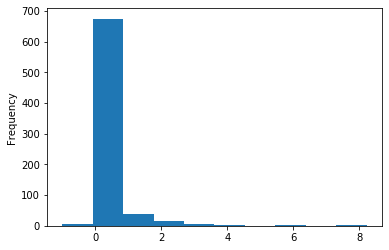

In [8]:
clean_df['Confirmed_lag'] = clean_df.groupby(['Province/State']).Confirmed.shift(1)

clean_df['growth number daily'] =  clean_df.Confirmed - clean_df.Confirmed_lag

clean_df['growth rate daily'] = clean_df.Confirmed / clean_df.Confirmed_lag - 1

clean_df[clean_df.Confirmed_lag > 0]['growth rate daily'].plot.hist()

In [9]:
clean_df['growth rate daily'].describe()

count    761.000000
mean            inf
std             NaN
min       -1.000000
25%        0.000000
50%        0.103704
75%        0.357143
max             inf
Name: growth rate daily, dtype: float64

In [10]:
# focus on cases where base is above 8
heavy_affect_df = clean_df[clean_df['Confirmed_lag'] >= 8]

heavy_affect_df['day count'] = heavy_affect_df.groupby('Province/State')['period'].rank()

heavy_affect_df.describe()

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Confirmed,Suspected,Recovered,Deaths,Confirmed_lag,growth number daily,growth rate daily,day count
count,407.000000,407.000000,407.000000,407.00000,407.000000,407.000000,407.000000,407.000000
mean,355.609337,1.098280,10.476658,7.58231,297.481572,58.127764,0.278680,6.056511
std,1589.509164,8.214799,47.140643,48.63676,1367.547131,293.386904,0.537333,3.509909
min,0.000000,0.000000,0.000000,0.00000,8.000000,-21.000000,-1.000000,1.000000
25%,23.000000,0.000000,0.000000,0.00000,18.000000,2.000000,0.041368,3.000000
50%,66.000000,0.000000,1.000000,0.00000,52.000000,9.000000,0.174174,6.000000
75%,178.500000,0.000000,5.000000,0.00000,153.500000,24.500000,0.348670,9.000000
max,16678.000000,117.000000,538.000000,479.00000,16678.000000,3268.000000,8.222222,14.000000


In [11]:
growth_df = heavy_affect_df.pivot_table(values = 'growth rate daily', index = 'day count', columns='Province/State').reset_index()
growth_df

Province/State,day count,Anhui,Beijing,Chongqing,Fujian,Gansu,Germany,Guangdong,Guangxi,Guizhou,...,Sichuan,Singapore,South Korea,Taiwan,Thailand,Tianjin,Vietnam,Xinjiang,Yunnan,Zhejiang
0,1.0,0.666667,0.571429,2.000000,0.800000,0.357143,0.25,0.230769,0.434783,0.000000,...,0.875000,0.000000,0.363636,0.000000,0.000000,0.625000,0.0,0.076923,0.727273,1.700000
1,2.0,3.000000,0.636364,1.777778,0.944444,0.263158,0.20,0.656250,0.393939,0.333333,...,1.933333,0.300000,0.000000,0.125000,0.750000,0.076923,0.0,0.214286,0.368421,0.592593
2,3.0,0.166667,0.416667,0.466667,0.685714,0.083333,0.00,0.849057,0.108696,0.250000,...,0.568182,0.384615,0.000000,0.111111,0.000000,0.642857,NaN,0.000000,0.692308,1.418605
3,4.0,0.514286,0.333333,0.200000,0.389831,0.115385,0.00,0.489796,0.137255,0.933333,...,0.304348,0.000000,0.066667,0.000000,0.000000,0.086957,NaN,0.235294,0.250000,0.230769
4,5.0,0.433962,0.176471,0.113636,0.231707,0.000000,NaN,0.034247,0.344828,0.310345,...,0.200000,0.000000,0.187500,0.000000,0.357143,0.080000,NaN,0.142857,0.381818,0.351562
5,6.0,0.315789,0.137500,0.122449,0.000000,0.379310,NaN,0.596026,0.115385,0.210526,...,0.314815,0.333333,NaN,0.000000,0.000000,0.185185,NaN,0.208333,0.092105,0.710983
6,7.0,0.185000,0.219780,0.248485,0.188119,0.275000,NaN,0.290456,0.000000,0.217391,...,0.246479,0.166667,NaN,0.100000,0.000000,0.000000,NaN,0.103448,0.120482,0.445946
7,8.0,0.000000,0.090090,0.024272,0.325000,0.078431,NaN,0.263666,0.275862,0.142857,...,0.000000,NaN,NaN,0.000000,0.000000,0.406250,NaN,0.000000,0.129032,0.254673
8,9.0,0.434599,0.148760,0.241706,0.000000,0.036364,NaN,0.109415,0.144144,0.000000,...,0.305085,NaN,NaN,NaN,0.315789,0.066667,NaN,NaN,0.114286,0.001862
9,10.0,0.200000,0.316547,0.145038,0.125786,0.087719,NaN,0.385321,0.094488,NaN,...,0.099567,NaN,NaN,NaN,0.000000,0.250000,NaN,NaN,0.042735,0.228625


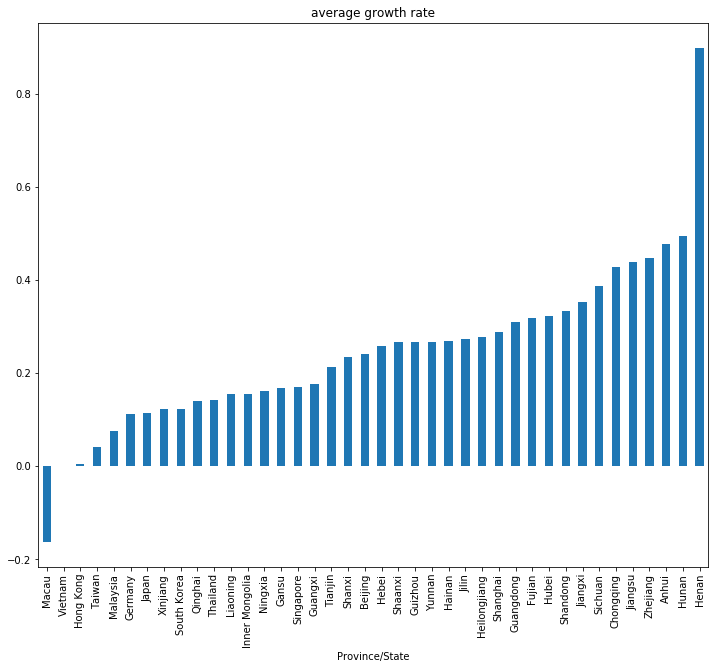

In [12]:
# arithmatic mean of growth rate
growth_df.set_index('day count').mean().sort_values().plot.bar(figsize=(12,10),
                                                              title='average growth rate')

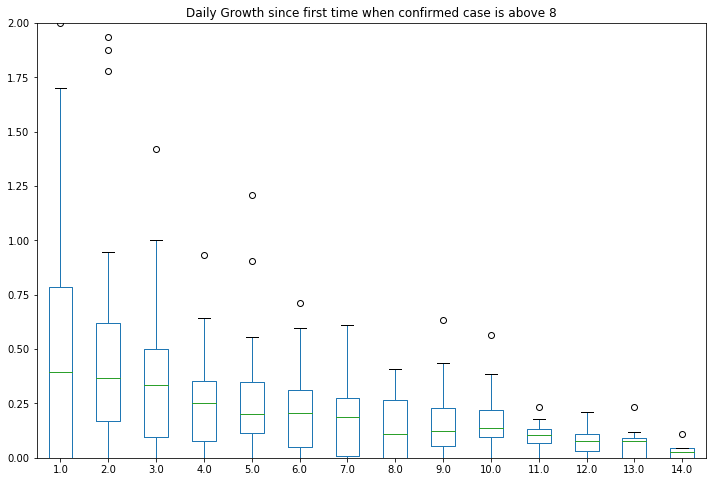

In [13]:
growth_df.set_index('day count').transpose().plot.box(figsize =(12, 8), 
                                         title ='Daily Growth since first time when confirmed case is above 8',
                                         ylim =(0, 2))

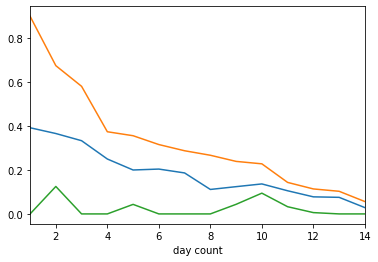

In [14]:
# deceleration? caveat: ommision bias
growth_df.set_index('day count').median(axis =1).plot()
growth_df.set_index('day count').quantile(q=0.8, axis =1).plot()
growth_df.set_index('day count').quantile(q=0.2, axis =1).plot()

In [15]:
# cumulative growth rate from base of the first time there is more than 8 "confirmed case"
earliest_df = heavy_affect_df. \
            groupby(['Province/State']). \
            agg({'Confirmed':'min'}).reset_index().rename(columns ={'Confirmed': 'base'})

earliest_df.sort_values(by='base',ascending=False).head()

,Province/State,base
14,Hubei,444
12,Henan,83
27,Shandong,39
19,Jiangxi,36
7,Guangxi,33


In [16]:
heavy_affect_df = pd.merge(heavy_affect_df, earliest_df, how = 'left', left_on = 'Province/State', right_on = 'Province/State')
heavy_affect_df

,Country/Region,Province/State,month,day,Last Update,Confirmed,Suspected,Recovered,Deaths,period,Confirmed_lag,growth number daily,growth rate daily,day count,base
0,Germany,Germany,Feb,02,2020-02-02 16:03:00,10,0,0,0,2020-02-02,8.0,2.0,0.250000,1.0,10
1,Germany,Germany,Feb,03,2020-02-03 18:53:00,12,0,0,0,2020-02-03,10.0,2.0,0.200000,2.0,10
2,Germany,Germany,Feb,04,2020-02-03 18:53:00,12,0,0,0,2020-02-04,12.0,0.0,0.000000,3.0,10
3,Germany,Germany,Feb,05,2020-02-03 18:53:00,12,0,0,0,2020-02-05,12.0,0.0,0.000000,4.0,10
4,Hong Kong,Hong Kong,Jan,27,2020-01-27 18:30:00,8,0,0,0,2020-01-27,8.0,0.0,0.000000,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,Thailand,Thailand,Feb,03,2020-01-31 08:37:00,19,0,5,0,2020-02-03,19.0,0.0,0.000000,8.0,8
403,Thailand,Thailand,Feb,04,2020-02-04 13:33:00,25,0,5,0,2020-02-04,19.0,6.0,0.315789,9.0,8
404,Thailand,Thailand,Feb,05,2020-02-04 13:33:00,25,0,5,0,2020-02-05,25.0,0.0,0.000000,10.0,8
405,Vietnam,Vietnam,Feb,04,2020-02-03 19:43:00,8,0,1,0,2020-02-04,8.0,0.0,0.000000,1.0,8


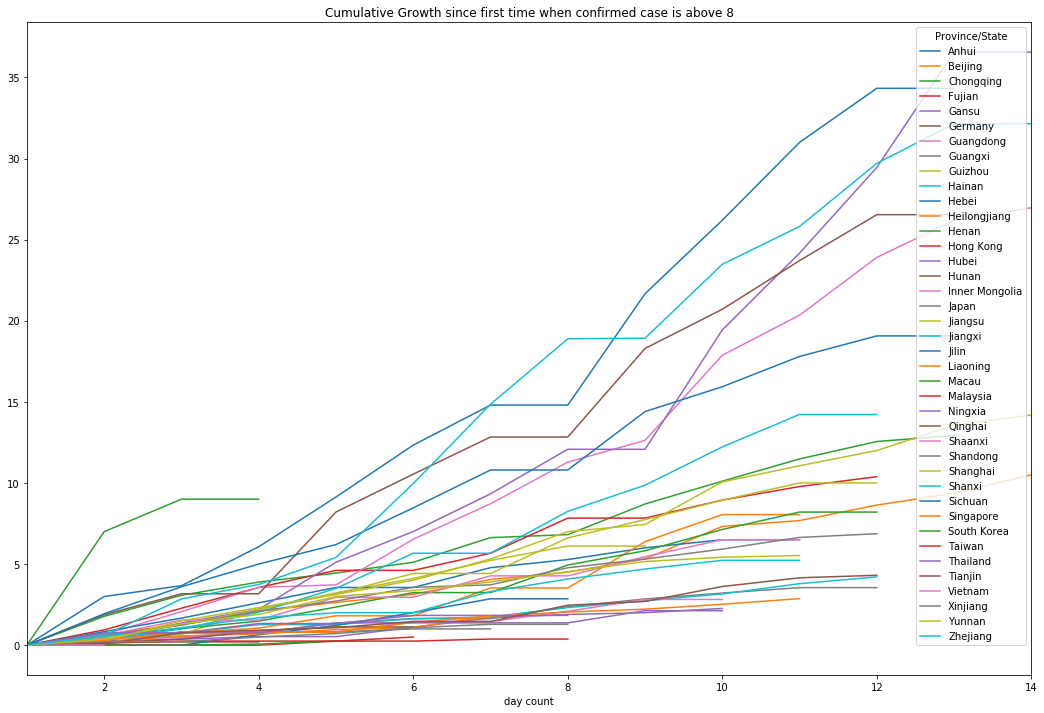

In [17]:
heavy_affect_df['cumulative growth'] = heavy_affect_df['Confirmed']/ heavy_affect_df['base'] - 1
cmlt_growth_df = heavy_affect_df.pivot_table(columns ='Province/State', index= 'day count', values='cumulative growth')
cmlt_growth_df.plot.line(figsize =(18, 12), 
                                         title ='Cumulative Growth since first time when confirmed case is above 8')

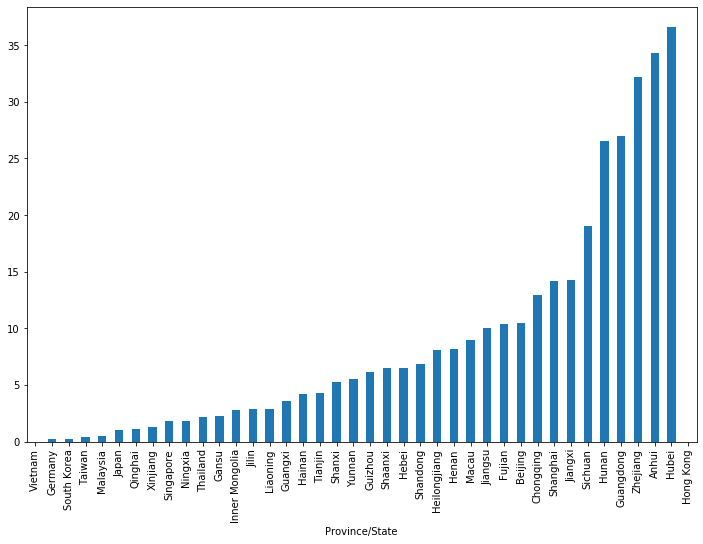

In [18]:
cmlt_growth_df.max().sort_values().plot.bar(figsize =(12,8))

In [19]:
cmlt_growth_df.max().sort_values().index

Index(['Vietnam', 'Germany', 'South Korea', 'Taiwan', 'Malaysia', 'Japan',
       'Qinghai', 'Xinjiang', 'Singapore', 'Ningxia', 'Thailand', 'Gansu',
       'Inner Mongolia', 'Jilin', 'Liaoning', 'Guangxi', 'Hainan', 'Tianjin',
       'Shanxi', 'Yunnan', 'Guizhou', 'Shaanxi', 'Hebei', 'Shandong',
       'Heilongjiang', 'Henan', 'Macau', 'Jiangsu', 'Fujian', 'Beijing',
       'Chongqing', 'Shanghai', 'Jiangxi', 'Sichuan', 'Hunan', 'Guangdong',
       'Zhejiang', 'Anhui', 'Hubei', 'Hong Kong'],
      dtype='object', name='Province/State')

In [20]:
# the following provinces/states have the highest cumulative growth
cmlt_growth_df[['Chongqing', 'Shanghai', 'Jiangxi', 'Sichuan', 'Guangdong', 'Hunan','Zhejiang', 'Anhui', 'Hubei']]

Province/State,Chongqing,Shanghai,Jiangxi,Sichuan,Guangdong,Hunan,Zhejiang,Anhui,Hubei
day count,,,,,,,,,
1.0,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2.0,1.777778,0.2500,0.333333,1.933333,0.65625,1.875000,0.592593,3.000000,0.236486
3.0,3.074074,1.5000,1.000000,3.600000,2.06250,3.166667,2.851852,3.666667,1.369369
4.0,3.888889,2.3125,2.027778,5.000000,3.56250,3.166667,3.740741,6.066667,2.204955
5.0,4.444444,3.1250,3.500000,6.200000,3.71875,8.208333,5.407407,9.133333,5.112613
6.0,5.111111,4.0000,5.666667,8.466667,6.53125,10.541667,9.962963,12.333333,7.004505
7.0,6.629630,5.3125,5.666667,10.800000,8.71875,12.833333,14.851852,14.800000,9.328829
8.0,6.814815,7.0000,8.250000,10.800000,11.28125,12.833333,18.888889,14.800000,12.076577
9.0,8.703704,7.4375,9.861111,14.400000,12.62500,18.291667,18.925926,21.666667,12.076577


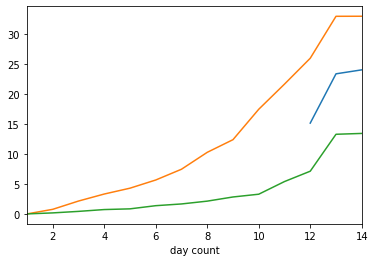

In [21]:
# deceleration? (caveat: ommited variable)
cmlt_growth_df.mean(axis=1).plot()
cmlt_growth_df.quantile(q=0.8,axis=1).plot()
cmlt_growth_df.quantile(q=0.2,axis=1).plot()

#### Compare China vs. Outside

In [22]:
# focus on countries outside of China
outside_df = clean_df[clean_df['Country/Region']!= 'Mainland China']

outside_agg_df = outside_df.groupby(['Country/Region','Province/State','period']). \
    agg({'Confirmed':'max','Recovered':'max','Suspected':'max','Deaths':'max'}).reset_index(). \
    groupby(['period']). \
    agg({'Confirmed':'sum','Recovered':'sum','Suspected':'sum','Deaths':'sum','Province/State':'count'}).reset_index()

## outside_agg_df['Confirmed lag'] = outside_agg_df.Confirmed.shift(1)

outside_agg_df['log_growth'] = np.log(outside_agg_df.Confirmed).diff()

In [23]:
china_df = clean_df[clean_df['Country/Region']=='Mainland China']

china_agg_df = china_df.groupby(['Country/Region','Province/State','period']). \
    agg({'Confirmed':'max','Recovered':'max','Suspected':'max','Deaths':'max'}).reset_index(). \
    groupby(['period']). \
    agg({'Confirmed':'sum','Recovered':'sum','Suspected':'sum','Deaths':'sum','Province/State':'count'}).reset_index()

china_agg_df['log_growth'] = np.log(china_agg_df.Confirmed).diff()

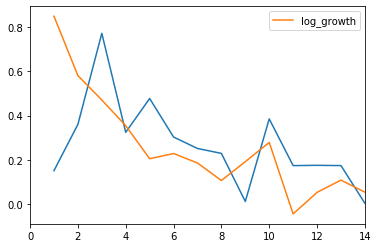

In [25]:
china_agg_df.log_growth.plot()
outside_agg_df.log_growth.plot(legend = True)

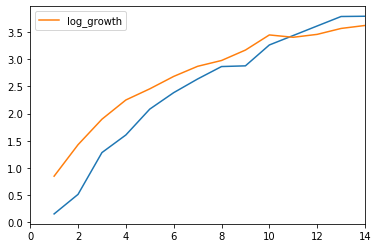

In [26]:
# cumulative growth
china_agg_df.log_growth.cumsum().plot()
outside_agg_df.log_growth.cumsum().plot(legend=True)

#### Time-series Analysis on Growth Rate

In [28]:
# auto-correlation
acf(china_agg_df['log_growth'].dropna())

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


array([ 1.        ,  0.18605187,  0.18757799,  0.10301818, -0.16586527,
        0.11017157, -0.2695079 ,  0.03231531, -0.08192248, -0.26050311,
       -0.11914686, -0.26141094, -0.0245312 ,  0.06375283])

In [29]:
# unable to run VAR due to missing values (synthetic control?)
model = AutoReg(china_agg_df['log_growth'].dropna(), lags=1)
results = model.fit()

results.summary()

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:             log_growth   No. Observations:                   14
Model:                     AutoReg(1)   Log Likelihood                   3.225
Method:               Conditional MLE   S.D. of innovations              0.189
Date:                Thu, 06 Feb 2020   AIC                             -2.873
Time:                        09:30:39   BIC                             -2.742
Sample:                             1   HQIC                            -2.899
                                   14                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.2178      0.100      2.186      0.029       0.023       0.413
log_growth.L1     0.2140      0.291      0.736      0.462      -0.356       0.784
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.6738           +0.0000j            4.6738            0.0000
-----------------------------------------------------------------------------
"""

##### Recover rate using the latest data available

In [30]:
clean_df['recover rate'] = clean_df.Recovered / clean_df.Confirmed
latest_df = clean_df.groupby(['Province/State']).agg({'Last Update': 'max'}).reset_index()
latest_df

,Province/State,Last Update
0,Anhui,2020-02-05 11:43:00
1,Arizona,2020-02-01 08:00:00
2,Australia,2020-01-27 07:00:00
3,Bavaria,2020-02-01 08:00:00
4,Beijing,2020-02-05 03:43:00
...,...,...
77,Vietnam,2020-02-03 19:43:00
78,Washington,2020-02-01 08:00:00
79,Xinjiang,2020-02-05 00:03:00
80,Yunnan,2020-02-05 05:43:00


In [31]:
latest_df = pd.merge(clean_df, latest_df, how = 'right', left_on = ['Province/State', 'Last Update'], right_on = ['Province/State', 'Last Update'])
latest_df

,Country/Region,Province/State,month,day,Last Update,Confirmed,Suspected,Recovered,Deaths,period,Confirmed_lag,growth number daily,growth rate daily,recover rate
0,Australia,Australia,Jan,27,2020-01-27 07:00:00,5,0,0,0,2020-01-27,4.0,1.0,0.250000,0.000
1,Australia,New South Wales,Feb,01,2020-02-01 16:12:00,4,0,2,0,2020-02-01,4.0,0.0,0.000000,0.500
2,Australia,New South Wales,Feb,02,2020-02-01 16:12:00,4,0,2,0,2020-02-02,4.0,0.0,0.000000,0.500
3,Australia,New South Wales,Feb,03,2020-02-01 16:12:00,4,0,2,0,2020-02-03,4.0,0.0,0.000000,0.500
4,Australia,New South Wales,Feb,04,2020-02-01 16:12:00,4,0,2,0,2020-02-04,4.0,0.0,0.000000,0.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,United Arab Emirates,United Arab Emirates,Feb,04,2020-02-02 03:43:00,5,0,0,0,2020-02-04,5.0,0.0,0.000000,0.000
155,United Arab Emirates,United Arab Emirates,Feb,05,2020-02-02 03:43:00,5,0,0,0,2020-02-05,5.0,0.0,0.000000,0.000
156,Vietnam,Vietnam,Feb,03,2020-02-03 19:43:00,8,0,1,0,2020-02-03,6.0,2.0,0.333333,0.125
157,Vietnam,Vietnam,Feb,04,2020-02-03 19:43:00,8,0,1,0,2020-02-04,8.0,0.0,0.000000,0.125


Percentage over total confirmed cases: 4.21%


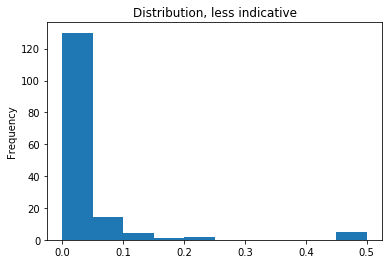

In [32]:
latest_df['recover rate'].plot.hist(title = 'Distribution, less indicative') # not much meaningful data is biased by many cases with very few confirmed case
print('Percentage over total confirmed cases: {0:.2%}'.format(latest_df.Recovered.sum() / latest_df.Confirmed.sum())) # ratio overall is more indicative

### ***Retired-*** 

In [33]:
# #### Alternative method choose worksheet before merging (read from Excel manually downloaded)

# file_path = 'Novel Coronavirus (2019-nCoV) Cases, provided by JHU CSSE.xlsx'
# # raw_df = pd.concat(pd.read_excel(file_path, sheet_name= None), ignore_index = True, sort=True)

# xl = pd.ExcelFile(file_path)
# xl.sheet_names

# # use the latest time for each date
# split_name_df = pd.DataFrame(data = list(map(lambda x: x.split('_'), xl.sheet_names)), columns =['date','hour'])
# split_name_df

# # extract time components
# split_name_df['suffix'] = split_name_df.hour.apply(lambda x: x[-2:])

# split_name_df['hour_digit'] = split_name_df.hour.str.extract(r'(?P<hour>[\d]+)')

# split_name_df['date_digit'] = split_name_df.date.str.extract('([\d]+)').astype(int)

# # deal with special case of 12am and half-hour

# split_name_df.loc[split_name_df.hour == '12am', 'date_digit'] = split_name_df.loc[split_name_df.hour == '12am', 'date_digit'] - 1

# split_name_df['hour_digit'] = split_name_df.hour_digit.str.replace('30','').astype(int)

# split_name_df.loc[split_name_df.hour == '12am', 'hour_digit'] = 24

# split_name_df.loc[split_name_df.hour == '12am', 'suffix'] = 'pm'

# # filter for the last file for each day

# filter_name_df = split_name_df[split_name_df.suffix == 'pm']

# filter_name_df = filter_name_df.groupby('date_digit').agg({'hour_digit':'max','suffix': 'max'}).reset_index()

# filter_name_df

# filter_name_df = pd.merge(split_name_df,filter_name_df, how = 'right', 
#          left_on = ['date_digit', 'hour_digit','suffix'], right_on = ['date_digit','hour_digit','suffix'])

# filter_name = (filter_name_df.date + '_' + filter_name_df.hour).to_list()
# filter_name

# main_2_df = pd.concat(pd.read_excel(file_path, sheet_name= filter_name), ignore_index = True)
# main_2_df['Last Update'].value_counts()

In [34]:
# def read_excel_sheets(xls_path):
#     """Read all sheets of an Excel workbook and return a single DataFrame"""
#     print(f'Loading {xls_path} into pandas')
#     xl = pd.ExcelFile(xls_path)
#     df = pd.DataFrame()
#     columns = None
#     for idx, name in enumerate(xl.sheet_names):
#         print(f'Reading sheet #{idx}: {name}')
#         sheet = xl.parse(name)
#         if idx == 0:
#             # Save column names from the first sheet to match for append
#             columns = sheet.columns
#         sheet.columns = columns
#         # Assume index of existing data frame when appended
#         df = df.append(sheet, ignore_index=True)
#     return df

# read_excel_sheets(file_name)